# Trainning a YOLOv4 Object Detector with Darknet in the Cloud! (GPU ENABLED)
This script will demonstrate how to setup and train Yolov4 weights using config files generated from PRT.
##Step 1 Setup Darknet on colab

In [ ]:
# clone darknet repository
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15412, done.
remote: Total 15412 (delta 0), reused 0 (delta 0), pack-reused 15412
Receiving objects: 100% (15412/15412), 14.04 MiB | 20.31 MiB/s, done.
Resolving deltas: 100% (10356/10356), done.


In [ ]:
# make sure GPU acceleration is turned on
# change makefile to have GPU and OPENCV enabled in the setup file
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile

/content/darknet/darknet


In [ ]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [ ]:
# function to change iteration for saving using darknet
def change_save_iteration(save_it=None):
  if save_it is None:
    print('saving every 1000 iterations <10000 iterations')
    print('saving every 10000 iterations >10000 iterations')
  else:
    file = open('./src/detector.c','r')
    lines = file.readlines()
    file.close()
    lines[393]=f'        if ((iteration >= (iter_save + {save_it}) || iteration % {save_it} == 0) ||\n'
    lines[394]=f'            (iteration >= (iter_save + {save_it}) || iteration % {save_it} == 0) && net.max_batches < 10000)\n'
    file = open('./src/detector.c','w') 
    print(lines)
    for line in lines:
      file.write(line)
    file.close()
    print(f'Saving every {save_it}')

In [ ]:
# function to change iteration for caluclating mAP using darknet
def change_map_cal(map_cal_it = None):
  if map_cal_it is None:
    print('Calculating mAP by default iteration')
  else:
    file = open('./src/detector.c','r')
    lines = file.readlines()
    file.close()
    lines[301] = f'        calc_map_for_each = fmax({map_cal_it}, {map_cal_it-1});\n'
    lines[303] = f'        next_map_calc = fmax(next_map_calc, 0);\n'
    file = open('./src/detector.c','w') 
    print(lines)
    for line in lines:
      file.write(line)
    file.close()
    print(f'mAP calculations every {map_cal_it}')

In [ ]:
# make darknet (builds darknet so that you can then use the darknet executable file to train object detectors)
# this will take a minute of two 
# if you need to change the save iteration or mAP calculated iteration you to run the change* funcitons before building darknet
# since darknet is written in c which needs to be compiled before runnning
change_save_iteration(100) # comment this line out if you want to save every 1000 iterations
change_map_cal(50)
!make

## Step 2: Link google drive

**NOTE:** We will be creating a symbolic link between '/content/gdrive/My\ Drive/' and '/mydrive.

This means we are just creating a shortcut '/mydrive' to map to the contents within the folder '/content/gdrive/My\ Drive/'.

The reason for this is that sometime having the space in 'My Drive' folder path can cause issues when running certain commands. This symbolic link will stop this from happening!

In [ ]:
#mount the drive at /content/gdrive
#Accept conditions in pop up window to mount your drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# this assumes that you have uploaded the trainning cfg folder in your main drive folder
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/trainning is equal to ./trainning/ in the darknet folder 
# check the contents of the trainning folder
!ln -s /content/gdrive/My\ Drive/trainning/ ./trainning
!ls ./trainning

chart.png    obj.data	test_set  train_set  yolov4-obj.cfg
checkpoints  obj.names	test.txt  train.txt


# Step 4: Download pre-trained weights for the convolutional layers.
This step downloads the weights for the convolutional layers of the YOLOv4 network. By using these weights it helps your custom object detector to be way more accurate and not have to train as long. You don't have to use these weights but trust me it will help your modle converge and be accurate way faster. 

In [ ]:
!wget https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

# Step 5: Train Your Custom Object Detector!
The time has finally come! You have made it to the moment of truth! You are now ready to train your custom YOLOv4 object detector on whatever crazy classes you have decided on. So run the following command. (-dont_show flag stops chart from popping up since Colab Notebook can't open images on the spot, -map flag overlays mean average precision on chart to see how accuracy of your model is, only add map flag if you have a validation dataset)
```
!./darknet detector train <path to obj.data> <path to custom config> yolov4.conv.137 -dont_show -map
```
**TIP:** This training could take several hours depending on how many iterations you chose in the .cfg file. You will want to let this run as you sleep or go to work for the day, etc. However, Colab Cloud Service kicks you off it's VMs if you are idle for too long (30-90 mins).

To avoid this hold (CTRL + SHIFT + i) at the same time to open up the inspector view on your browser.

Paste the following code into your console window and hit **Enter**
```
function ClickConnect(){
console.log("Working"); 
document
  .querySelector('#top-toolbar > colab-connect-button')
  .shadowRoot.querySelector('#connect')
  .click() 
}
setInterval(ClickConnect,30000)
```
Looks like this, it will click the screen every 10 minutes so that you don't get kicked off for being idle! HACKS!

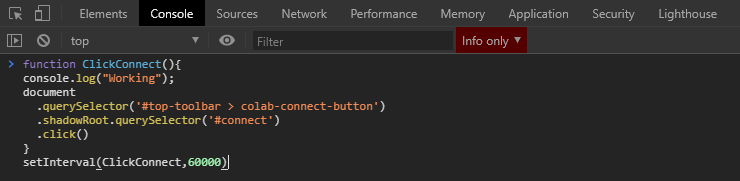

In [42]:
# train your custom detector! (uncomment %%capture below if you run into memory issues or your Colab is crashing)
# %%capture
# the log file of the trainning is written to the trainning cfg folder, you can view the results of the trainning later
!./darknet detector train ./trainning/obj.data ./trainning/yolov4-obj.cfg yolov4.conv.137 -map -dont_show |tee ./trainning/log.txt

Darknet error location: ./src/dark_cuda.c, check_error, line #69
CUDA Error: no CUDA-capable device is detected: Bad file descriptor
CUDA status Error: file: ./src/dark_cuda.c : () : line: 38 : build time: May  6 2022 - 19:50:33 

 CUDA Error: no CUDA-capable device is detected


**TRICK**: If for some reason you get an error or your Colab goes idle during training, you have not lost your partially trained model and weights! Every 100 iterations (or whatever you have defined) a weights file called **yolov4-obj_last.weights** is saved to **trainning/backup/** folder. This is why we created this folder in our Google drive and not on the cloud VM. If your runtime crashes and your backup folder was in your cloud VM you would lose your weights and your training progress.

We can kick off training from our last saved weights file so that we don't have to restart! Run the following command but with your backup location.
```
!./darknet detector train data/obj.data cfg/yolov4-obj.cfg /mydrive/yolov4/backup/yolov4-obj_last.weights -dont_show
```

In [ ]:
# kick off training from where it last saved
!./darknet detector train data/obj.data cfg/yolov4-obj.cfg ./trainning/yolov4-obj_last.weights -dont_show -map |tee ./trainning/log2.txt # remember to save a differnt log file

# Step 6: Checking the Mean Average Precision (mAP) of Your Model
If you didn't run the training with the '-map- flag added then you can still find out the mAP of your model after training. Run the following command on any of the saved weights from the training to see the mAP value for that specific weight's file. I would suggest to run it on multiple of the saved weights to compare and find the weights with the highest mAP as that is the most accurate one!

**NOTE:** If you think your final weights file has overfitted then it is important to run these mAP commands to see if one of the previously saved weights is a more accurate model for your classes.

In [46]:
!./darknet detector map data/obj.data cfg/yolov4-obj.cfg /mydrive/tracker_training/backup/yolov4-obj_best2.weights

/bin/bash: ./darknet: Is a directory


# Step 7: Run Your Custom Object Detector!!!
You have done it! You now have a custom object detector to make your very own detections. Time to test it out and have some fun!

# Thanks!
Thanks for using this darknet tutorial or PyRodentTracks, hopefully it will be helpful for your research or application

Special mention and thanks to [The AI Guy](https://www.youtube.com/channel/UCrydcKaojc44XnuXrfhlV8Q) Their tutorials and videos really helped and inspired with creating this notebook 